# Lab 5 : Mixture Models+Model orden selection 

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MSc - TD5"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L5_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## Question 1 : Optimization of the expected value of the log-likelihood

To optimize the expected value of the log-likelihood in the M-step of the EM algorithm for GMM, we update the parameters based on the current estimates. Here are the updates for the mixture weights, means, and covariance matrices:

1) The expression for the updated mixture weight $(\pi_k^{n+1})$ is given by:

$$
\pi_k^{n+1} = \frac{1}{N} \sum_{i=1}^{N} \gamma(z_{ik})
$$

where $(\gamma(z_{ik}))$ is the responsibility, which is the probability that data point \(x_i\) belongs to cluster \(k\).

2) The expression for the updated mean $(\mu_k^{n+1})$ of each component is calculated as the weighted average of the data points:

$$
\mu_k^{n+1} = \frac{\sum_{i=1}^{N} \gamma(z_{ik}) x_i}{\sum_{i=1}^{N} \gamma(z_{ik})}
$$

where the weights are the responsibilities from the E-step.

3) The expression for the updated covariance matrix $(\Sigma_k^{n+1})$ of each component is:

$$
\Sigma_k^{n+1} = \frac{\sum_{i=1}^{N} \gamma(z_{ik}) (x_i - \mu_k^{n+1})(x_i - \mu_k^{n+1})^T}{\sum_{i=1}^{N} \gamma(z_{ik})}
$$

These parameters are iteratively updated in the EM algorithm until the log-likelihood converges, which indicates that the parameters are well-suited to the data.


## Question 2 : Implementation of the EM algorithm

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

$\mu = \frac{1}{n} \sum_{i=1}^n x_i$

In [3]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse


In [36]:
class my_GMM():
    
    def __init__(self, k):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
    def update_labels(self):
        """Update the label assignment to the data points based on current parameters."""
        self.labels_ = np.argmax(self.cond_prob_, axis=1)
        
    def fit(self, X, max_iters=100, init_params='random' , plot_iters = False):
        """ Find the parameters that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        max_iters: int
            Maximum number of iterations for the algorithm
        init_params: str
            Method of initialization ('kmeans' or 'random')
        
        Returns:
        -----
        self
        """
        
        n, p = X.shape
        self.alpha_ = np.ones(self.k) / self.k
        
        if init_params == 'kmeans':
            kmeans = KMeans(n_clusters=self.k).fit(X)
            self.mu_ = kmeans.cluster_centers_
            self.Sigma_ = np.array([np.cov(X.T) for _ in range(self.k)])
        elif init_params == 'random':
            self.mu_ = X[np.random.choice(n, self.k, replace=False)]
            self.Sigma_ = np.array([np.eye(p)] * self.k)  # Initialize to identity matrices

        log_likelihood = -np.inf
        threshold = 1e-3  # Set a threshold for convergence

        iteration = 0  # Initialize iteration counter
        while True:
            self.cond_prob_ = self.compute_condition_prob_matrix(X)
            self.update_labels()
            self.alpha_ = self.cond_prob_.mean(axis=0)
            for i in range(self.k):
                resp = self.cond_prob_[:, i].reshape(-1, 1)
                total_resp = resp.sum()
                self.mu_[i] = (X * resp).sum(axis=0) / total_resp
                self.Sigma_[i] = np.cov(X.T, aweights=(resp/total_resp).flatten(), bias=True)
            
            # Plot the current state of the GMM
            if plot_iters:
                self.plot_current_state(X, iteration)
            
            # Compute new log likelihood and check for convergence
            new_log_likelihood = np.sum(np.log(np.sum(self.cond_prob_ * self.alpha_, axis=1)))
            if np.abs(new_log_likelihood - log_likelihood) < threshold:
                break
            log_likelihood = new_log_likelihood
            iteration += 1  # Increment the iteration counter

        self.labels_ = self.cond_prob_.argmax(axis=1)
        return self

    def plot_current_state(self, X, iteration):
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=self.labels_, palette='deep', zorder=1)
        plt.title(f'Iteration {iteration}')
        for mean, cov in zip(self.mu_, self.Sigma_):
            self.plot_ellipse(mean, cov)
        plt.legend(title='Cluster')
        plt.show()
        
    def plot_ellipse(self, mean, cov):
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        theta = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))

        width, height = 2 * np.sqrt(eigenvalues)
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor='r', fc='None', lw=2, zorder=2)
        plt.gca().add_patch(ellipse)
    
    def compute_condition_prob_matrix(self, X):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
        
        # TODO:
        # initialize the parameters
        # apply sklearn kmeans or randomly initialize them
        
        # While not(convergence)
        #     Compute conditional probability matrix
        #     Update parameters
        
        # Update labels_
        
        # Return self
        
            n = X.shape[0]
            cond_prob = np.zeros((n, self.k))
            for i in range(self.k):
                distribution = multivariate_normal(mean=self.mu_[i], cov=self.Sigma_[i], allow_singular=True)  # allow_singular=True to handle non-invertible covariance matrices
                cond_prob[:, i] = distribution.pdf(X) * self.alpha_[i]
            cond_prob /= cond_prob.sum(axis=1, keepdims=True)  # Normalizing probabilities
            return cond_prob
    
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        # TODO
        cond_prob = self.compute_condition_prob_matrix(X)
        return cond_prob.argmax(axis=1)
        
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        # TODO
        
        return self.compute_condition_prob_matrix(X)
    

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

In [37]:
import numpy as np

# Set the parameters for the Gaussian components
mean1 = [0, 0]  # Mean of the first component
cov1 = [[1, 0.5], [0.5, 1]]  # Covariance matrix of the first component

mean2 = [3, 3]  # Mean of the second component
cov2 = [[1, -0.5], [-0.5, 1]]  # Covariance matrix of the second component

# Seed the random number generator for reproducibility
np.random.seed(0)

# Generate samples for each component
data1 = np.random.multivariate_normal(mean1, cov1, size=300)
data2 = np.random.multivariate_normal(mean2, cov2, size=300)

# Combine the two datasets into a single test dataset
test_data = np.vstack((data1, data2))

# Display the shape of the test dataset and the first few samples
print("Shape of the test dataset:", test_data.shape)
print("First 5 samples:\n", test_data[:5])

# The 'test_data' is now ready to be used as a test dataset for the EM algorithm implementation.


Shape of the test dataset: (600, 2)
First 5 samples:
 [[-1.72779275 -1.32763554]
 [-1.96805856  0.27283464]
 [-1.12871372 -2.1059916 ]
 [-0.7471221  -0.89847931]
 [-0.1159091   0.2946894 ]]


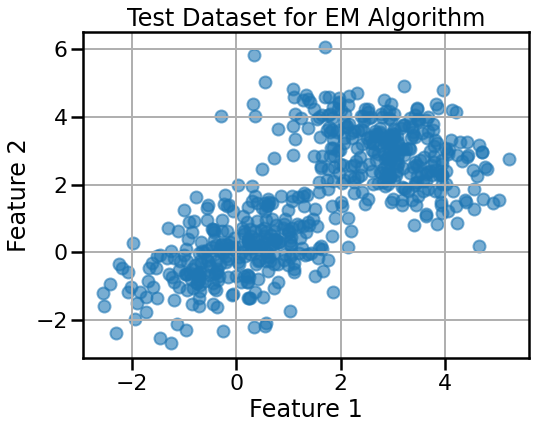

In [38]:
import matplotlib.pyplot as plt

# Plot the generated test data
plt.figure(figsize=(8, 6))
plt.scatter(test_data[:, 0], test_data[:, 1], alpha=0.6)
plt.title('Test Dataset for EM Algorithm')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()


#### I have included two ways of intializing 
- Random
- Using K-means. 

For test_data like this, K means already does a pretty good job with initializing. So for the visualization reasons, I've initialized randomly. 

We can always change this by passing init_params = 'kmeans' in fit method. 

#### Below after fitting the data, we can see plots till the algorithm converges.

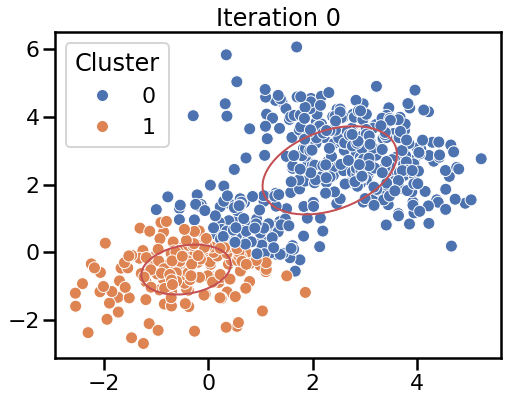

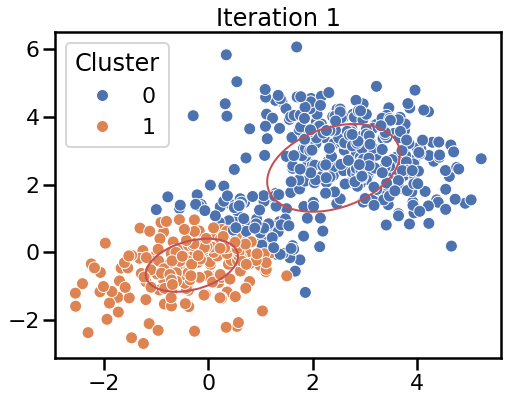

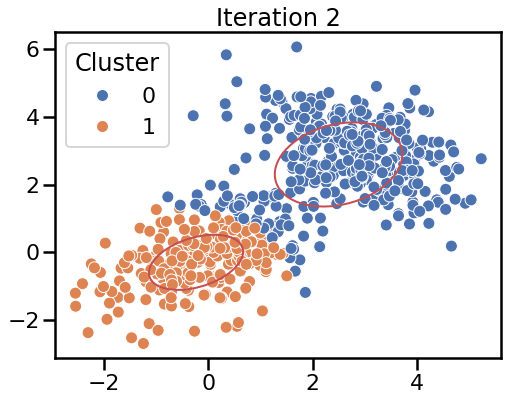

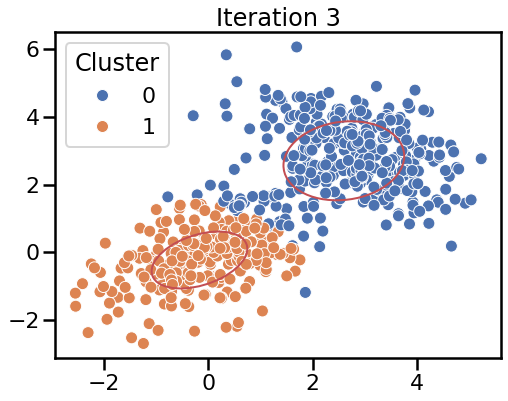

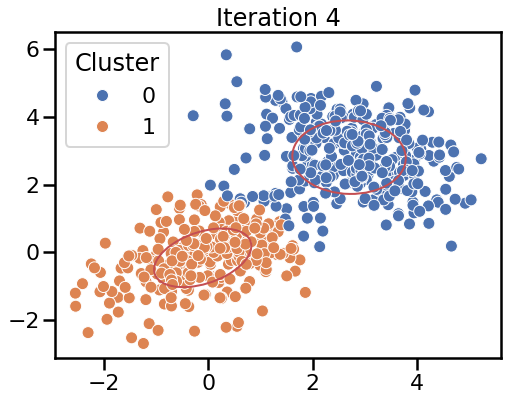

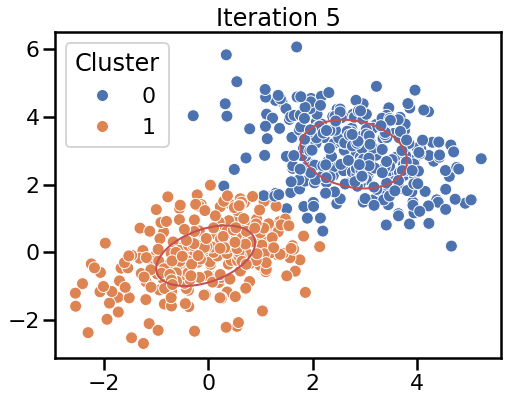

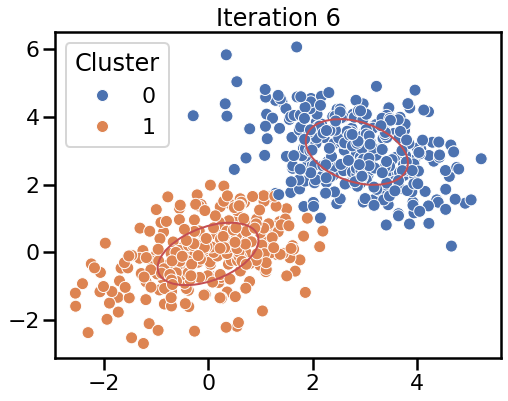

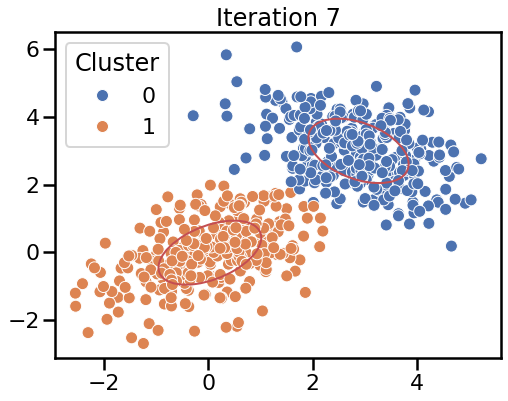

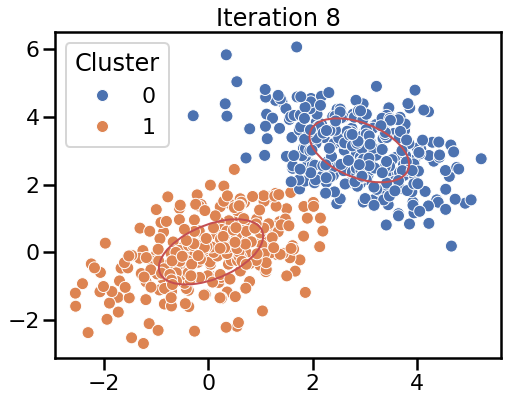

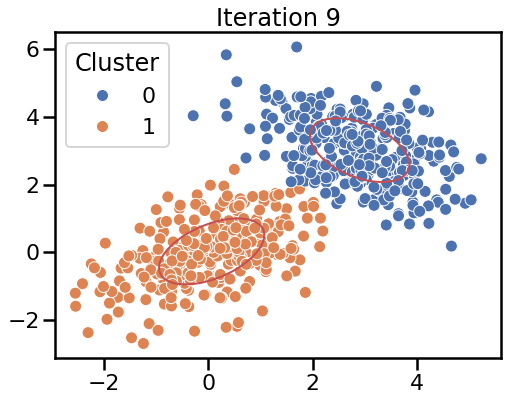

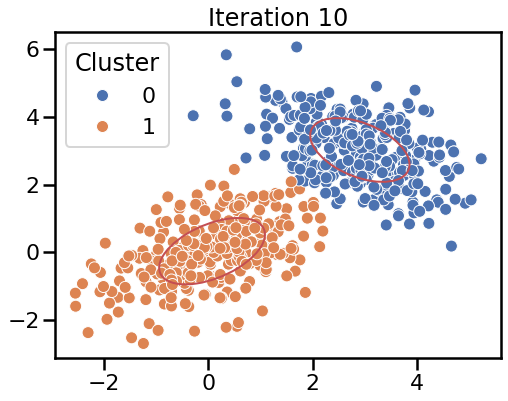

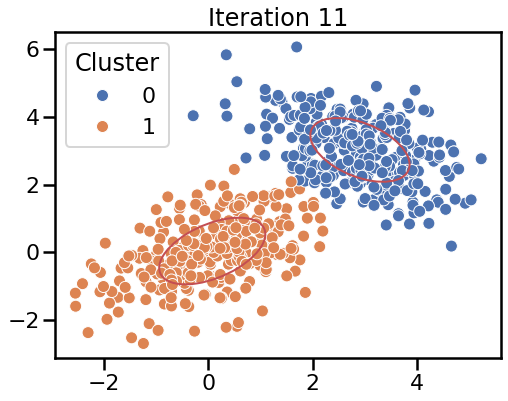

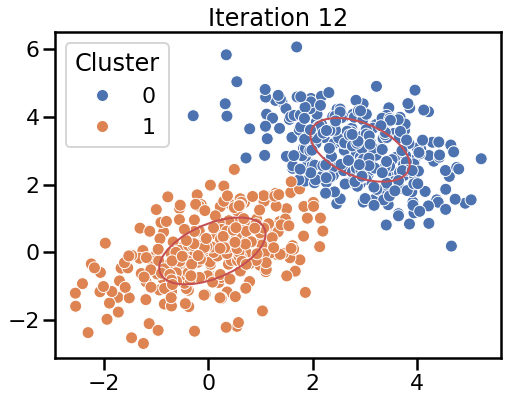

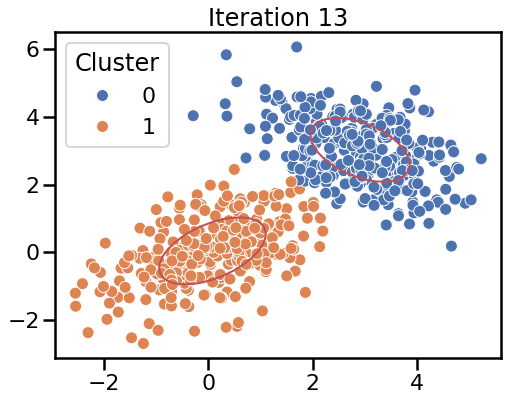

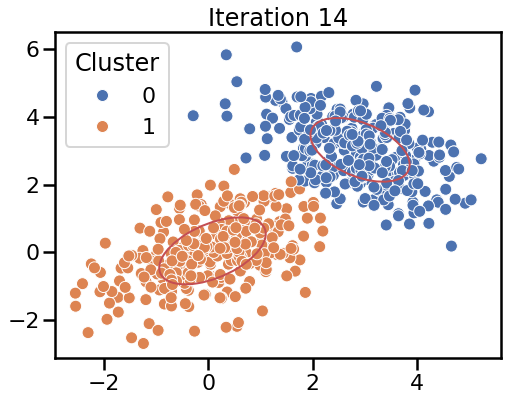

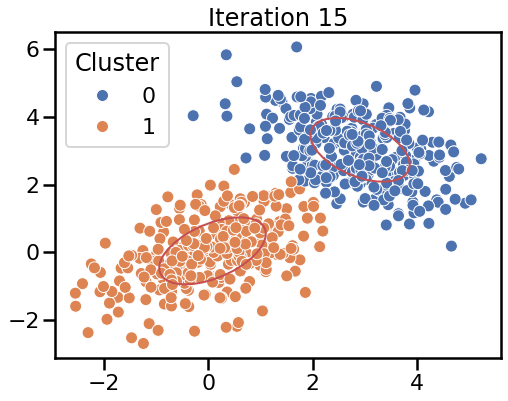

In [39]:
gmm = my_GMM(k=2) 
gmm.fit(test_data, plot_iters= True)


<Figure size 576x576 with 0 Axes>

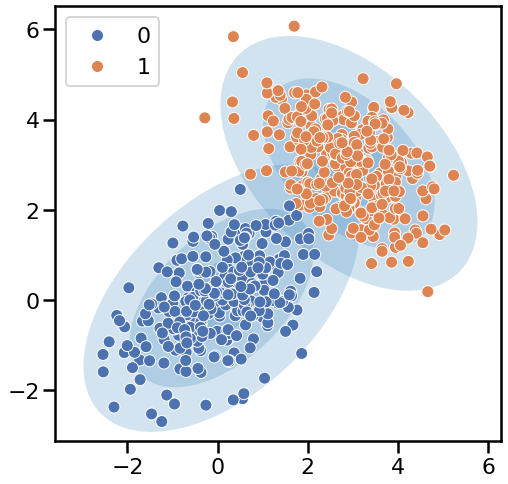

In [40]:
gmm = my_GMM(k=2) 
gmm.fit(test_data)


labels = gmm.predict(test_data)


def plot_gmm(gmm, X, label=True, ax=None):
    
    if ax is None:
        plt.figure(figsize=(8, 8))
        ax = plt.gca()

    labels = gmm.predict(X)
    
    # Use Seaborn to plot the data points
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='deep', ax=ax, zorder=2, legend='full' if label else False)
    
    # Set the aspect of the plot to be equal
    ax.axis('equal')

    # Plot the ellipses
    w_factor = 0.2 / gmm.alpha_.max()
    for pos, covar, w in zip(gmm.mu_, gmm.Sigma_, gmm.alpha_):
        draw_ellipse(pos, covar, alpha=w * w_factor, ax=ax)

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ellipse = Ellipse(position, nsig * width, nsig * height, angle=angle, **kwargs)
        ax.add_patch(ellipse)

plt.figure(figsize=(8, 8))
plot_gmm(gmm, test_data)
plt.show()

#### Plotting with Kmeans

Text(0.5, 1.0, 'clustered_kmeans')

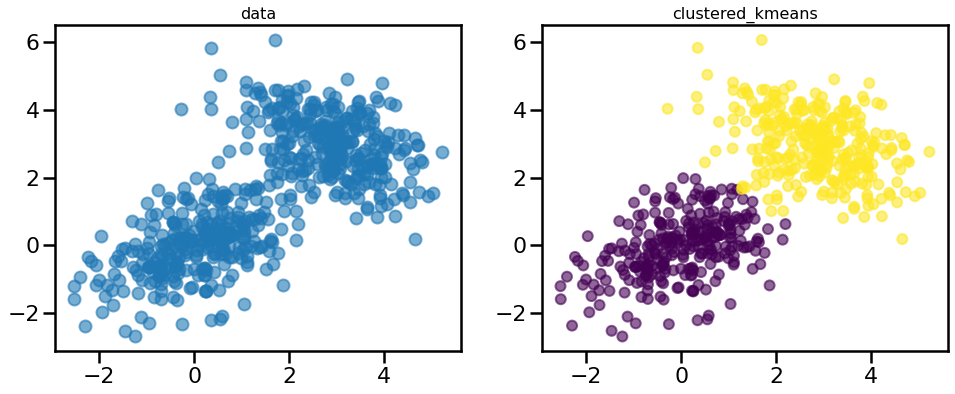

In [41]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=2, max_iter=200).fit(test_data)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data[:, 0], test_data[:, 1], alpha=0.6)
ax[0].set_title('data', size=16)

ax[1].scatter(test_data.T[0], test_data.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[1].set_title('clustered_kmeans', size=16)



#### Comparing my GMM class with Kmeans

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


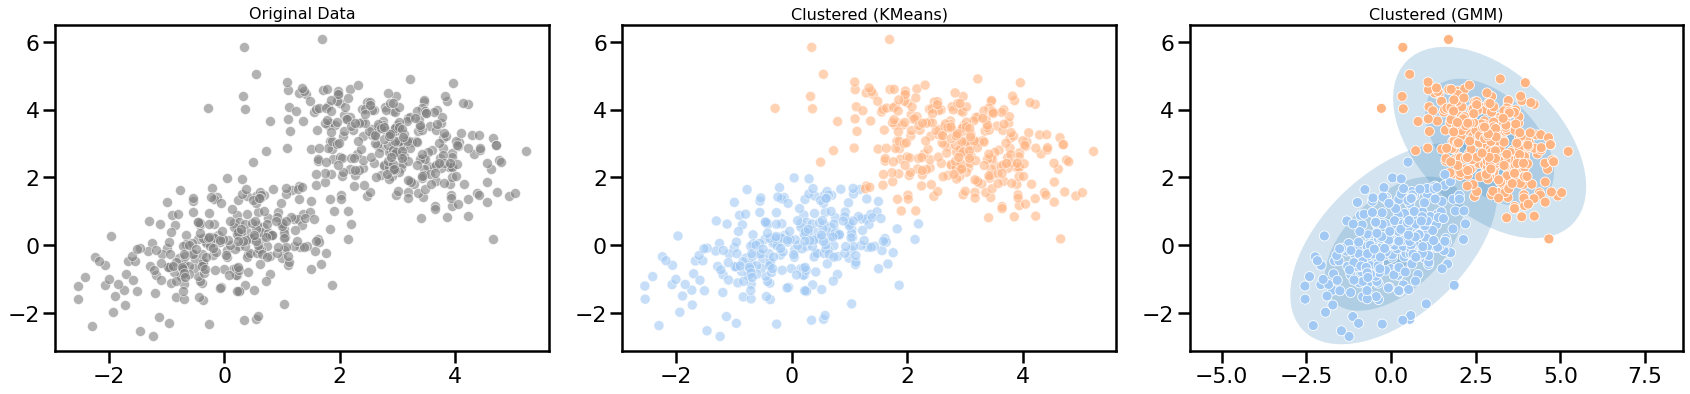

In [52]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse



# Fit KMeans
kmeans_0 = KMeans(n_clusters=2, max_iter=200).fit(test_data)

sns.color_palette("crest", as_cmap=True)
# Fit GMM
gmm = my_GMM(k=2)  
gmm.fit(test_data)

# Plotting function for GMM
def plot_gmm(gmm, X, ax, label=True):
    labels = gmm.predict(X)
    if label:
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='pastel', ax=ax, s=100, zorder=2)
    else:
        sns.scatterplot(x=X[:, 0], y=X[:, 1], ax=ax, s=100, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.alpha_.max()
    for pos, covar, w in zip(gmm.mu_, gmm.Sigma_, gmm.alpha_):
        draw_ellipse(pos, covar, alpha=w * w_factor, ax=ax)

# Function to draw an ellipse
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ellipse = Ellipse(position, nsig * width, nsig * height, angle=angle, **kwargs)
        ax.add_patch(ellipse)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(24, 6))  # Adjusted for 3 subplots

# Plot original data
sns.scatterplot(x=test_data[:, 0], y=test_data[:, 1], ax=axs[0], color='grey', **plot_kwds)
axs[0].set_title('Original Data', size=16)

# Plot KMeans results
sns.scatterplot(x=test_data[:, 0], y=test_data[:, 1], hue=kmeans_0.labels_, palette='pastel', ax=axs[1], **plot_kwds)
axs[1].set_title('Clustered (KMeans)', size=16)

# Plot GMM results
plot_gmm(gmm, test_data, axs[2])
axs[2].set_title('Clustered (GMM)', size=16)


axs[0].legend().set_visible(False)
axs[1].legend().set_visible(False)
axs[2].legend().set_visible(False)

plt.tight_layout()
plt.show()


## Generating additional test data for 3 and 4 clusters to compare results 

In [34]:
import numpy as np

np.random.seed(42)  # For reproducibility

# Dataset for 3 clusters
mean3_1, cov3_1 = [0, 3], [[1, 0.8], [0.8, 2]]  
mean3_2, cov3_2 = [2, 0], [[2, -0.5], [-0.5, 1]] 
mean3_3, cov3_3 = [-1, -1], [[0.5, 0], [0, 0.5]]  


data3_1 = np.random.multivariate_normal(mean3_1, cov3_1, size=300)
data3_2 = np.random.multivariate_normal(mean3_2, cov3_2, size=180)
data3_3 = np.random.multivariate_normal(mean3_3, cov3_3, size=120)
test_data_3_clusters = np.vstack((data3_1, data3_2, data3_3))

# Dataset for 4 clusters
mean4_1, cov4_1 = [1, 1], [[1, 0.6], [0.6, 1]] 
mean4_2, cov4_2 = [-1, 2], [[1, -0.3], [-0.3, 1]]  
mean4_3, cov4_3 = [2, -2], [[1, 0.5], [0.5, 1]]  
mean4_4, cov4_4 = [-2, -2], [[1.5, 0], [0, 1.5]]  

data4_1 = np.random.multivariate_normal(mean4_1, cov4_1, size=150)
data4_2 = np.random.multivariate_normal(mean4_2, cov4_2, size=150)
data4_3 = np.random.multivariate_normal(mean4_3, cov4_3, size=100)
data4_4 = np.random.multivariate_normal(mean4_4, cov4_4, size=200)
test_data_4_clusters = np.vstack((data4_1, data4_2, data4_3, data4_4))


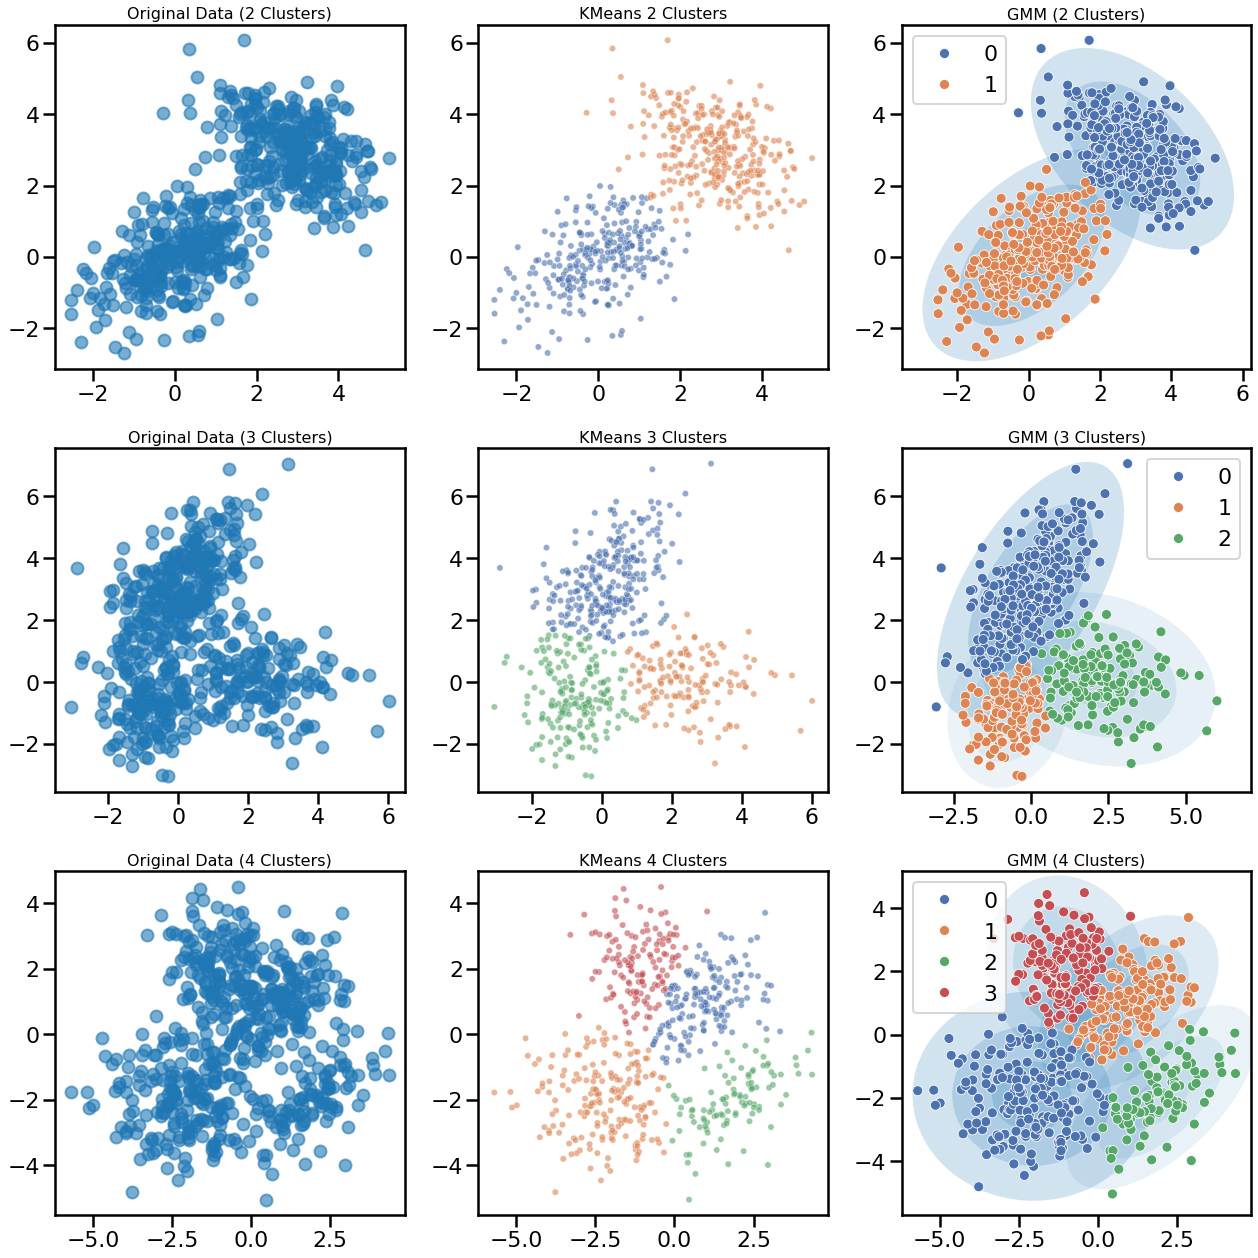

In [46]:
fig, ax = plt.subplots(3, 3, figsize=(18, 18))

# Helper function to plot KMeans and GMM results
def plot_clusters(ax, data, k):
    # KMeans
    kmeans = KMeans(n_clusters=k, max_iter=200).fit(data)
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=kmeans.labels_, palette='pastel', ax=ax, s=40, alpha=0.6)
    ax.set_title(f'KMeans {k} Clusters', size=16)
    ax.legend().set_visible(False)  # Optionally hide the legend for clarity

    
# GMM
def plot_clusters_gmm(ax, data, k):
    gmm = my_GMM(k=k)
    gmm.fit(data)
    plot_gmm(gmm, data, ax=ax)
    

# Plot for 2 clusters
ax[0, 0].scatter(test_data[:, 0], test_data[:, 1], alpha=0.6)
ax[0, 0].set_title('Original Data (2 Clusters)', size=16)
plot_clusters(ax[0, 1], test_data, 2)
plot_clusters_gmm(ax[0, 2], test_data, 2)
ax[0, 2].set_title('GMM (2 Clusters)', size=16)

# Plot for 3 clusters
ax[1, 0].scatter(test_data_3_clusters[:, 0], test_data_3_clusters[:, 1], alpha=0.6)
ax[1, 0].set_title('Original Data (3 Clusters)', size=16)
plot_clusters(ax[1, 1], test_data_3_clusters, 3)
plot_clusters_gmm(ax[1, 2], test_data_3_clusters, 3)

ax[1, 2].set_title('GMM (3 Clusters)', size=16)

# Plot for 4 clusters
ax[2, 0].scatter(test_data_4_clusters[:, 0], test_data_4_clusters[:, 1], alpha=0.6)
ax[2, 0].set_title('Original Data (4 Clusters)', size=16)
plot_clusters(ax[2, 1], test_data_4_clusters, 4)
plot_clusters_gmm(ax[2, 2], test_data_4_clusters, 4)
ax[2, 2].set_title('GMM (4 Clusters)', size=16)

plt.tight_layout()
plt.show()


## Conclusion 

GMM seems is more flexible and accurate in capturing the structure of the data due to its probabilistic nature. It can handle different cluster shapes and sizes, which KMeans cannot. The final results show that GMM has identified clusters that align better with the underlying distribution, especially for non-spherical clusters.